In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import pyspark
from pyspark.sql import SparkSession, functions as F
import matplotlib.pyplot as plt
import pandas as pd

os.environ["SPARK_HOME"] = pyspark.__path__[0]
os.environ["PYSPARK_DRIVER_PYTHON"] = "python"
os.environ["PYSPARK_PYTHON"] = "python"

spark = (
    SparkSession.builder
    .config("spark.driver.memory", "8g")
    .getOrCreate()
)

In [3]:
levels = spark.read.csv("../data/20210801_all_levels.csv", header=True, inferSchema=True).cache()
ranking = spark.read.csv("../data/20210801_all_ranking.csv", header=True, inferSchema=True).cache()

levels.createOrReplaceTempView("levels")
ranking.createOrReplaceTempView("ranking")

levels.printSchema()
ranking.printSchema()

root
 |-- level: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- timestamp: string (nullable = true)

root
 |-- name: string (nullable = true)
 |-- level: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- specialization: string (nullable = true)
 |-- mastery: string (nullable = true)
 |-- fame: integer (nullable = true)
 |-- guild: string (nullable = true)
 |-- rank: integer (nullable = true)



In [4]:
level = 30
pivot_expr = ",".join([f"min(if(level=={i}, diff_seconds, null)) as ttl_{i}" for i in range(level) if i > 2])

df = spark.sql(f"""
with jobs as (
    select name, job
    from ranking
),
ttl as (
    select
        name,
        job,
        level,
        first(timestamp) over (partition by name order by level) as start_ts,
        unix_timestamp(from_utc_timestamp(timestamp, "Z"))
            - unix_timestamp(from_utc_timestamp(lag(timestamp) over (partition by name order by level), "Z"))
            as diff_seconds,
        unix_timestamp(from_utc_timestamp(timestamp, "Z"))
            - unix_timestamp(from_utc_timestamp(first(timestamp) over (partition by name order by level), "Z"))
            as cum_diff_seconds
    from levels
    join jobs
    using (name)
),
pivoted as (
    select
        name,
        job,
        min(if(level={level} and diff_seconds is not null, cum_diff_seconds, 
            unix_timestamp(from_utc_timestamp("2021-08-01", "Z")) 
            - unix_timestamp(from_utc_timestamp(start_ts, "Z"))
        )) as duration,
        max(if(level={level}, 1, 0)) as observed,
        {pivot_expr}
    from ttl
    group by name, job
)
select * from pivoted
where duration >=0
""")
#             if(
#                 unix_timestamp(from_utc_timestamp("2021-08-01", "Z")) 
#                 - unix_timestamp(from_utc_timestamp(start_ts, "Z")) > 60*60*24*365,
#                 60*60*24*365,
#                 unix_timestamp(from_utc_timestamp("2021-08-01", "Z")) 
#                 - unix_timestamp(from_utc_timestamp(start_ts, "Z"))
#             )
df.show(vertical=True, n=1)

-RECORD 0------------
 name     | 12er34   
 job      | pirate   
 duration | 43034638 
 observed | 0        
 ttl_3    | 383      
 ttl_4    | 122      
 ttl_5    | 137      
 ttl_6    | 349      
 ttl_7    | 919      
 ttl_8    | 1426     
 ttl_9    | 267      
 ttl_10   | 5980     
 ttl_11   | 1045     
 ttl_12   | 437      
 ttl_13   | 49046    
 ttl_14   | 1315     
 ttl_15   | 1068     
 ttl_16   | null     
 ttl_17   | null     
 ttl_18   | null     
 ttl_19   | null     
 ttl_20   | null     
 ttl_21   | null     
 ttl_22   | null     
 ttl_23   | null     
 ttl_24   | null     
 ttl_25   | null     
 ttl_26   | null     
 ttl_27   | null     
 ttl_28   | null     
 ttl_29   | null     
only showing top 1 row



In [5]:
pdf = df.toPandas()

<AxesSubplot:>

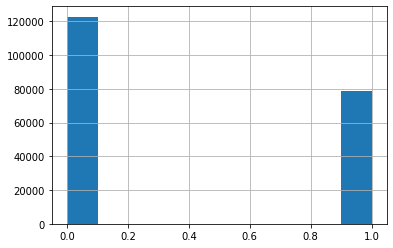

In [6]:
pdf.observed.hist()

<AxesSubplot:>

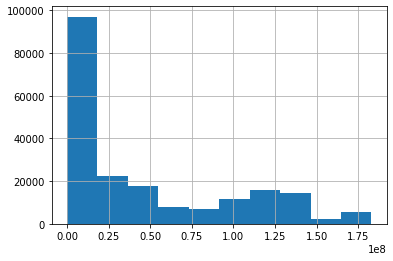

In [7]:
pdf.duration.hist()

In [8]:
pdf

,name,job,duration,observed,ttl_3,ttl_4,ttl_5,ttl_6,ttl_7,ttl_8,...,ttl_20,ttl_21,ttl_22,ttl_23,ttl_24,ttl_25,ttl_26,ttl_27,ttl_28,ttl_29
0,12er34,pirate,43034638,0,383.0,122.0,137.0,349.0,919.0,1426.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17thBaam,beginner,41470477,0,60.0,117.0,149.0,26.0,115.0,291.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1Pilot,beginner,132477527,0,18841.0,190.0,275.0,104070.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2cool4school,pirate,125216454,0,2297.0,87.0,239.0,157.0,484.0,914.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3mploy3d,warrior,243887,1,164.0,181.0,167.0,125.0,701.0,645.0,...,1975.0,1947.0,28664.0,7672.0,3320.0,1702.0,1732.0,129157.0,2278.0,2379.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201417,zLegend,thief,592622,1,160.0,170.0,154.0,325.0,1006.0,1001.0,...,24415.0,1114.0,80604.0,131406.0,1683.0,1686.0,259447.0,273.0,47698.0,2778.0
201418,zevelbatahat,beginner,159972811,0,67.0,106.0,121.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201419,ziv201,warrior,16023304,0,442.0,338.0,275.0,452.0,839.0,1592.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201420,zolet,warrior,638909,1,45.0,100.0,80.0,278.0,439.0,85140.0,...,1340.0,1261.0,151395.0,2558.0,1254.0,9315.0,3720.0,143530.0,31006.0,46194.0


In [9]:
pdf.duration/(24*60*60)

0          498.086088
1          479.982373
2         1533.304711
3         1449.264514
4            2.822766
             ...     
201417       6.859051
201418    1851.537164
201419     185.454907
201420       7.394780
201421     845.790463
Name: duration, Length: 201422, dtype: float64

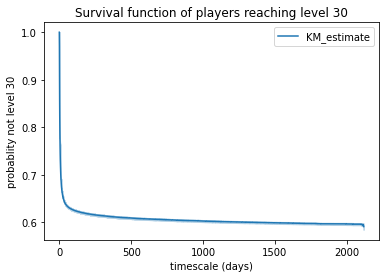

In [15]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
kmf.fit(pdf.duration/(24*60*60), event_observed=pdf.observed)

kmf.plot_survival_function()
plt.title('Survival function of players reaching level 30');
plt.ylabel("probablity not level 30")
plt.xlabel("timescale (days)")
plt.show()

In [14]:
kmf.percentile(0.95)

1.0496759259259258

In [16]:
from lifelines.statistics import logrank_test

a = pdf[pdf.job == "thief"]
b = pdf[pdf.job == "warrior"]
sec_per_day = 60*60*24
results = logrank_test(a.duration/sec_per_day, b.duration/sec_per_day, a.observed, b.observed, alpha=0.95)
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         910.11 <0.005    661.75

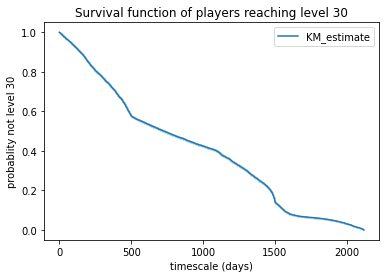

In [17]:
kmf = KaplanMeierFitter()
kmf.fit(pdf.duration/(24*60*60), event_observed=(pdf.observed != 1).astype(int))

kmf.plot_survival_function()
plt.title('Survival function of players reaching level 30');
plt.ylabel("probablity not level 30")
plt.xlabel("timescale (days)")
plt.show()

In [18]:
kmf.percentile(0.95)

77.11114583333334

In [19]:
from lifelines.statistics import logrank_test

a = pdf[pdf.job == "archer"]
b = pdf[pdf.job == "warrior"]
sec_per_day = 60*60*24
results = logrank_test(a.duration/sec_per_day, b.duration/sec_per_day, (a.observed != 1).astype(int), (b.observed != 1).astype(int), alpha=0.95)
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 0
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic   p  -log2(p)
           0.00 NaN       NaN

In [20]:
pdf.duration

0          43034638
1          41470477
2         132477527
3         125216454
4            243887
            ...    
201417       592622
201418    159972811
201419     16023304
201420       638909
201421     73076296
Name: duration, Length: 201422, dtype: int64

In [21]:
pdf

,name,job,duration,observed,ttl_3,ttl_4,ttl_5,ttl_6,ttl_7,ttl_8,...,ttl_20,ttl_21,ttl_22,ttl_23,ttl_24,ttl_25,ttl_26,ttl_27,ttl_28,ttl_29
0,12er34,pirate,43034638,0,383.0,122.0,137.0,349.0,919.0,1426.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17thBaam,beginner,41470477,0,60.0,117.0,149.0,26.0,115.0,291.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1Pilot,beginner,132477527,0,18841.0,190.0,275.0,104070.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2cool4school,pirate,125216454,0,2297.0,87.0,239.0,157.0,484.0,914.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3mploy3d,warrior,243887,1,164.0,181.0,167.0,125.0,701.0,645.0,...,1975.0,1947.0,28664.0,7672.0,3320.0,1702.0,1732.0,129157.0,2278.0,2379.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201417,zLegend,thief,592622,1,160.0,170.0,154.0,325.0,1006.0,1001.0,...,24415.0,1114.0,80604.0,131406.0,1683.0,1686.0,259447.0,273.0,47698.0,2778.0
201418,zevelbatahat,beginner,159972811,0,67.0,106.0,121.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201419,ziv201,warrior,16023304,0,442.0,338.0,275.0,452.0,839.0,1592.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201420,zolet,warrior,638909,1,45.0,100.0,80.0,278.0,439.0,85140.0,...,1340.0,1261.0,151395.0,2558.0,1254.0,9315.0,3720.0,143530.0,31006.0,46194.0


In [22]:
x = pdf.drop(columns=["name", "job"]).fillna(0)
x

,duration,observed,ttl_3,ttl_4,ttl_5,ttl_6,ttl_7,ttl_8,ttl_9,ttl_10,...,ttl_20,ttl_21,ttl_22,ttl_23,ttl_24,ttl_25,ttl_26,ttl_27,ttl_28,ttl_29
0,43034638,0,383.0,122.0,137.0,349.0,919.0,1426.0,267.0,5980.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,41470477,0,60.0,117.0,149.0,26.0,115.0,291.0,118.0,39.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,132477527,0,18841.0,190.0,275.0,104070.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,125216454,0,2297.0,87.0,239.0,157.0,484.0,914.0,209.0,696.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,243887,1,164.0,181.0,167.0,125.0,701.0,645.0,216.0,440.0,...,1975.0,1947.0,28664.0,7672.0,3320.0,1702.0,1732.0,129157.0,2278.0,2379.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201417,592622,1,160.0,170.0,154.0,325.0,1006.0,1001.0,378.0,452.0,...,24415.0,1114.0,80604.0,131406.0,1683.0,1686.0,259447.0,273.0,47698.0,2778.0
201418,159972811,0,67.0,106.0,121.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
201419,16023304,0,442.0,338.0,275.0,452.0,839.0,1592.0,2812.0,718.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
201420,638909,1,45.0,100.0,80.0,278.0,439.0,85140.0,872.0,70258.0,...,1340.0,1261.0,151395.0,2558.0,1254.0,9315.0,3720.0,143530.0,31006.0,46194.0


In [23]:
from lifelines import CoxPHFitter

cph = CoxPHFitter()
cph.fit(x, duration_col="duration", event_col="observed")
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 201422 total observations, 122691 right-censored observations>
             duration col = 'duration'
                event col = 'observed'
      baseline estimation = breslow
   number of observations = 201422
number of events observed = 78731
   partial log-likelihood = -941469.59
         time fit was run = 2021-08-09 05:43:05 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
ttl_3      -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
ttl_4      -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
ttl_5      -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
ttl_6      -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
ttl_7      -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
ttl_8      -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
ttl_9      -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
ttl_10     -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
ttl_11     -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
ttl_12     -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
ttl_13     -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
ttl_14     -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
ttl_15     -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
ttl_16     -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
ttl_17     -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
ttl_18     -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
ttl_19     -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ttl_20     -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ttl_21     -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ttl_22     -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ttl_23      0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ttl_24      0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ttl_25      0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
ttl_26      0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
ttl_27      0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
ttl_28      0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
ttl_29      0.00       1.00       0.00             0.00             0.00                 1.00                 1.00

               z      p   -log2(p)
covariate                         
ttl_3      -3.82 <0.005      12.85
ttl_4      -3.76 <0.005      12.50
ttl_5      -3.92 <0.005      13.46
ttl_6      -4.04 <0.005      14.21
ttl_7      -4.52 <0.005      17.32
ttl_8      -6.69 <0.005      35.40
ttl_9 

In [24]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(pdf.job)
le.classes_

array(['beginner', 'bowman', 'magician', 'pirate', 'thief', 'warrior'],
      dtype=object)

In [25]:
x = pdf.copy().drop(columns=["name"]).fillna(0)
x["job"] = le.transform(pdf.job)
x

,job,duration,observed,ttl_3,ttl_4,ttl_5,ttl_6,ttl_7,ttl_8,ttl_9,...,ttl_20,ttl_21,ttl_22,ttl_23,ttl_24,ttl_25,ttl_26,ttl_27,ttl_28,ttl_29
0,3,43034638,0,383.0,122.0,137.0,349.0,919.0,1426.0,267.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,41470477,0,60.0,117.0,149.0,26.0,115.0,291.0,118.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,132477527,0,18841.0,190.0,275.0,104070.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,125216454,0,2297.0,87.0,239.0,157.0,484.0,914.0,209.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,243887,1,164.0,181.0,167.0,125.0,701.0,645.0,216.0,...,1975.0,1947.0,28664.0,7672.0,3320.0,1702.0,1732.0,129157.0,2278.0,2379.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201417,4,592622,1,160.0,170.0,154.0,325.0,1006.0,1001.0,378.0,...,24415.0,1114.0,80604.0,131406.0,1683.0,1686.0,259447.0,273.0,47698.0,2778.0
201418,0,159972811,0,67.0,106.0,121.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
201419,5,16023304,0,442.0,338.0,275.0,452.0,839.0,1592.0,2812.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
201420,5,638909,1,45.0,100.0,80.0,278.0,439.0,85140.0,872.0,...,1340.0,1261.0,151395.0,2558.0,1254.0,9315.0,3720.0,143530.0,31006.0,46194.0


In [26]:
cph = CoxPHFitter()
cph.fit(x, duration_col="duration", event_col="observed")
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 201422 total observations, 122691 right-censored observations>
             duration col = 'duration'
                event col = 'observed'
      baseline estimation = breslow
   number of observations = 201422
number of events observed = 78731
   partial log-likelihood = -935217.91
         time fit was run = 2021-08-09 05:44:06 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
job         0.22       1.24       0.00             0.21             0.22                 1.24                 1.25
ttl_3      -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
ttl_4      -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
ttl_5      -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
ttl_6      -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
ttl_7      -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
ttl_8      -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
ttl_9      -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
ttl_10     -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
ttl_11     -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
ttl_12     -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
ttl_13     -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
ttl_14     -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
ttl_15     -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
ttl_16     -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
ttl_17     -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
ttl_18     -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
ttl_19     -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
ttl_20     -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
ttl_21     -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
ttl_22     -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
ttl_23     -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ttl_24      0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ttl_25      0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ttl_26      0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
ttl_27      0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
ttl_28      0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
ttl_29      0.00       1.00       0.00             0.00             0.00                 1.00                 1.00

               z      p   -log2(p)
covariate                         
job       109.68 <0.005        inf
ttl_3      -3.41 <0.005      10.56
ttl_4      -2.74   0.01       7

## Only keep characters that are about to level

In [27]:
level = 5
pivot_expr = ",".join([f"min(if(level=={i}, diff_seconds, null)) as ttl_{i}" for i in range(level) if i > 2])

df = spark.sql(f"""
with jobs as (
    select name, job
    from ranking
),
ttl as (
    select
        name,
        job,
        level,
        first(timestamp) over (partition by name order by level) as first_ts,
        lag(timestamp) over (partition by name order by level) as last_ts,
        unix_timestamp(from_utc_timestamp(timestamp, "Z"))
            - unix_timestamp(from_utc_timestamp(lag(timestamp) over (partition by name order by level), "Z"))
            as diff_seconds,
        unix_timestamp(from_utc_timestamp(timestamp, "Z"))
            - unix_timestamp(from_utc_timestamp(first(timestamp) over (partition by name order by level), "Z"))
            as cum_diff_seconds
    from levels
    join jobs
    using (name)
),
pivoted as (
    select
        name,
        job,
        min(if(level={level} and diff_seconds is not null, diff_seconds, 
            unix_timestamp(from_utc_timestamp("2021-08-01", "Z")) 
            - unix_timestamp(from_utc_timestamp(last_ts, "Z"))
        )) as duration,
        max(if(level={level}, 1, 0)) as observed,
        {pivot_expr}
    from ttl
    group by name, job
)
select * from pivoted
where
    duration >=0
    and ttl_{level-2} is not null
""")
pdf = df.toPandas()
pdf

,name,job,duration,observed,ttl_3,ttl_4
0,12er34,pirate,137,1,383,122.0
1,17thBaam,beginner,149,1,60,117.0
2,1Pilot,beginner,275,1,18841,190.0
3,2cool4school,pirate,239,1,2297,87.0
4,3mploy3d,warrior,167,1,164,181.0
...,...,...,...,...,...,...
195850,zLegend,thief,154,1,160,170.0
195851,zevelbatahat,beginner,121,1,67,106.0
195852,ziv201,warrior,275,1,442,338.0
195853,zolet,warrior,80,1,45,100.0


<AxesSubplot:>

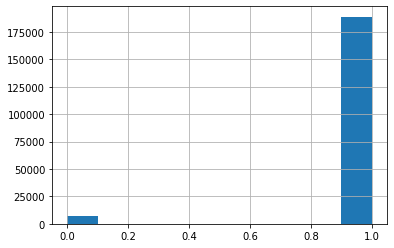

In [28]:
pdf.observed.hist()

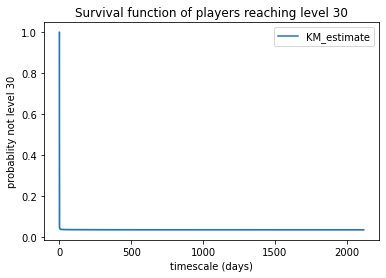

0.0020717592592592593

In [29]:
kmf = KaplanMeierFitter()
kmf.fit(pdf.duration/(24*60*60), event_observed=pdf.observed)

kmf.plot_survival_function()
plt.title('Survival function of players reaching level 30');
plt.ylabel("probablity not level 30")
plt.xlabel("timescale (days)")
plt.show()

kmf.percentile(0.5)

In [30]:
a = pdf[pdf.job == "thief"]
b = pdf[pdf.job == "warrior"]
sec_per_day = 60*60*24
results = logrank_test(a.duration/sec_per_day, b.duration/sec_per_day, a.observed, b.observed, alpha=0.99)
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        1369.28 <0.005    993.26

In [31]:
x = pdf.drop(columns=["name", "job"]).fillna(0).copy()
x["duration"] = x.duration/sec_per_day
cph = CoxPHFitter()
cph.fit(x, duration_col="duration", event_col="observed")
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 195855 total observations, 6881 right-censored observations>
             duration col = 'duration'
                event col = 'observed'
      baseline estimation = breslow
   number of observations = 195855
number of events observed = 188974
   partial log-likelihood = -2136678.11
         time fit was run = 2021-08-09 05:45:17 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
ttl_3      -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
ttl_4      -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00

              z      p   -log2(p)
covariate                        
ttl_3     -3.71 <0.005      12.22
ttl_4     -3.37 <0.005      10.35
---
Concordance = 0.61
Partial AIC = 4273360.23
log-likelihood ratio test = 30.90 on 2 df
-log2(p) of ll-ratio test = 22.29

In [32]:
x.head()

,duration,observed,ttl_3,ttl_4
0,0.001586,1,383,122.0
1,0.001725,1,60,117.0
2,0.003183,1,18841,190.0
3,0.002766,1,2297,87.0
4,0.001933,1,164,181.0


In [33]:
cph.predict_survival_function(x.head())

,0,1,2,3,4
0.000012,0.999995,0.999995,0.999995,0.999995,0.999995
0.000023,0.999985,0.999985,0.999985,0.999985,0.999985
0.000035,0.999974,0.999974,0.999974,0.999974,0.999974
0.000046,0.999964,0.999964,0.999964,0.999964,0.999964
0.000058,0.999944,0.999944,0.999944,0.999944,0.999944
...,...,...,...,...,...
2115.590579,0.034956,0.034956,0.034976,0.034958,0.034956
2115.831655,0.034956,0.034956,0.034976,0.034958,0.034956
2116.120903,0.034956,0.034956,0.034976,0.034958,0.034956
2116.919016,0.034956,0.034956,0.034976,0.034958,0.034956


In [34]:
r = cph.compute_residuals(x, 'martingale')
r.head()

,duration,observed,martingale
24118,0.000012,True,0.999995
88654,0.000023,True,0.999985
188976,0.000023,True,0.999985
106853,0.000035,True,0.999974
160539,0.000035,True,0.999974


<AxesSubplot:xlabel='duration', ylabel='martingale'>

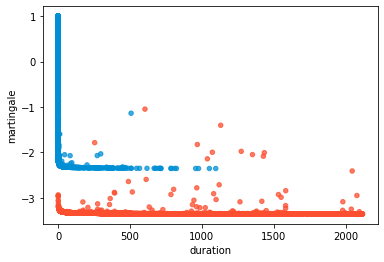

In [35]:
import numpy as np
r.plot.scatter(
    x='duration', y='martingale', c=np.where(r['observed'], '#008fd5', '#fc4f30'),
    alpha=0.75
)